# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import sys
import sklearn
from keras.datasets import mnist
import time
from sklearn.cluster import KMeans

# Basic K-means

#### helper functions

In [2]:
from sklearn import metrics

# from [1]
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels


def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))
    
def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

#### train & test

In [3]:
# Basic K-means [1]

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


In [4]:
# preprocessing the images

# convert each image to 1 dimensional array
X = np.concatenate((x_train, x_test))
X = X.reshape(len(X),-1)

Y = np.concatenate((y_train, y_test))

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print("Flattened shape of all full dataset: ",X.shape)
print("Flattened shape of one image",X[0].shape)
n_digits = len(np.unique(y_test))
print('Number of unique labels:',n_digits)

Flattened shape of all full dataset:  (70000, 784)
Flattened shape of one image (784,)
Number of unique labels: 10


In [5]:
# train the model
k_means = KMeans(n_clusters=n_digits)
k_means.fit(X)
k_means.labels_

array([8, 3, 0, ..., 4, 8, 7])

In [6]:
# print cluster metrics
calculate_metrics(k_means, X, Y)
# determine predicted labels
cluster_labels = infer_cluster_labels(k_means, Y)
predicted_Y = infer_data_labels(k_means.labels_, cluster_labels)

# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 10
Inertia: 2744527.503802019
Homogeneity: 0.48195411050270603
Accuracy: 0.5807142857142857



# VQ-VAE 

In [7]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)

        return encoding_indices

In [9]:
# modification made here to original code is add 1 more layers
# source [2]
def get_encoder(latent_dim=1):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 5, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 5, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="valid")(x)
    
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=1):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="valid")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(64, 5, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 5, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [10]:
def get_vqvae(latent_dim=1, num_embeddings=32):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 3, 3, 1)           126081    
                                                                 
 vector_quantizer (VectorQua  (None, 3, 3, 1)          32        
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         257665    
                                                                 
Total params: 383,778
Trainable params: 383,778
Non-trainable params: 0
_________________________________________________________________


In [11]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=1, num_embeddings=32, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [33]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


x_train = np.expand_dims(x_train, -1)
x_train_scaled = (x_train / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)


Y = y_train

print("Shape of all full dataset: ",x_train_scaled.shape)

n_digits = len(np.unique(Y))

print('Number of unique labels:',n_digits)

Shape of all full dataset:  (60000, 28, 28, 1)
Number of unique labels: 10


In [13]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=1, num_embeddings=32)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

In [14]:
vqvae_trainer.fit(x_train_scaled, epochs=100, batch_size=64)

Epoch 1/100
938/938 [==============================] - 175s 33ms/step - loss: 2.1781 - reconstruction_loss: 0.5090 - vqvae_loss: 1.4331
Epoch 2/100
938/938 [==============================] - 32s 34ms/step - loss: 0.5600 - reconstruction_loss: 0.3040 - vqvae_loss: 0.2415
Epoch 3/100
938/938 [==============================] - 32s 34ms/step - loss: 0.3799 - reconstruction_loss: 0.2696 - vqvae_loss: 0.1043
Epoch 4/100
938/938 [==============================] - 33s 35ms/step - loss: 0.3245 - reconstruction_loss: 0.2532 - vqvae_loss: 0.0677
Epoch 5/100
938/938 [==============================] - 30s 32ms/step - loss: 0.2952 - reconstruction_loss: 0.2422 - vqvae_loss: 0.0515
Epoch 6/100
938/938 [==============================] - 32s 34ms/step - loss: 0.2687 - reconstruction_loss: 0.2343 - vqvae_loss: 0.0337
Epoch 7/100
938/938 [==============================] - 32s 34ms/step - loss: 0.2513 - reconstruction_loss: 0.2280 - vqvae_loss: 0.0231
Epoch 8/100
938/938 [==============================] -

### run the encoder on the mnist dataset

In [15]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(x_train_scaled)

1875/1875 [==============================] - 9s 5ms/step


In [16]:
shape = encoded_outputs.shape
img_shape = encoded_outputs[1].shape

print("shape of the dataset:",shape)
print("shape of a single image:",img_shape)

shape of the dataset: (60000, 3, 3, 1)
shape of a single image: (3, 3, 1)


In [17]:
# flatten the image data

encoded_outputs = encoded_outputs.reshape(60000, 9)

print("shape of the dataset:",encoded_outputs.shape)

shape of the dataset: (60000, 9)


In [18]:
# train the model
k_means = KMeans(n_clusters=n_digits)
k_means.fit(encoded_outputs)
k_means.labels_

array([1, 5, 8, ..., 1, 7, 1])

In [19]:
# print cluster metrics
calculate_metrics(k_means, encoded_outputs, Y)
# determine predicted labels
cluster_labels = infer_cluster_labels(k_means, Y)
predicted_Y = infer_data_labels(k_means.labels_, cluster_labels)

# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 10
Inertia: 2301916.75
Homogeneity: 0.6451638258340754
Accuracy: 0.7474166666666666



### k-means on encoded test data

In [34]:
x_test = np.expand_dims(x_test, -1)
x_test_scaled = (x_test / 255.0) - 0.5

encoded_outputs = encoder.predict(x_test_scaled)

313/313 [==============================] - 3s 9ms/step


In [35]:
# flatten the image data

encoded_outputs = encoded_outputs.reshape(10000, 9)

print("shape of the dataset:",encoded_outputs.shape)

shape of the dataset: (10000, 9)


In [36]:
k_means = KMeans(n_clusters=n_digits)
k_means.fit(encoded_outputs)
k_means.labels_

array([6, 0, 4, ..., 7, 3, 5])

In [37]:
# print cluster metrics
calculate_metrics(k_means, encoded_outputs, y_test)
# determine predicted labels
cluster_labels = infer_cluster_labels(k_means, y_test)
predicted_Y = infer_data_labels(k_means.labels_, cluster_labels)

# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_Y)))

Number of Clusters: 10
Inertia: 354155.375
Homogeneity: 0.6570114115179496
Accuracy: 0.7539



## Visualizations

10


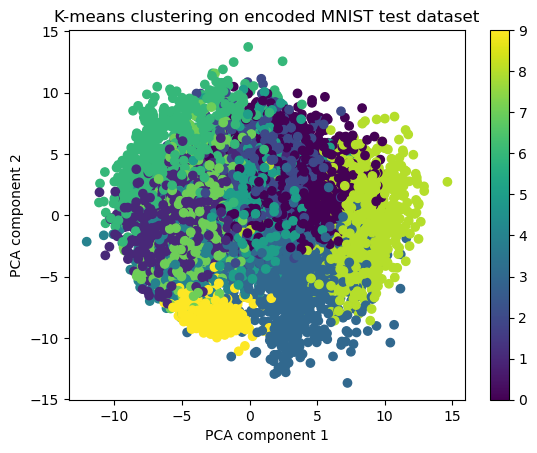

In [38]:
from sklearn.decomposition import PCA
# Reduce dimensionality of the data to 2 dimensions using PCA

estimator = KMeans(n_clusters = 10)
estimator.fit(encoded_outputs)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(encoded_outputs)

print(n_digits)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=k_means.labels_, cmap='viridis')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('K-means clustering on encoded MNIST test dataset')
plt.colorbar()
plt.show()

1/1 [==============================] - 1s 1s/step


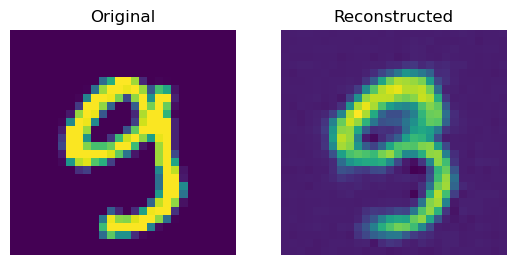

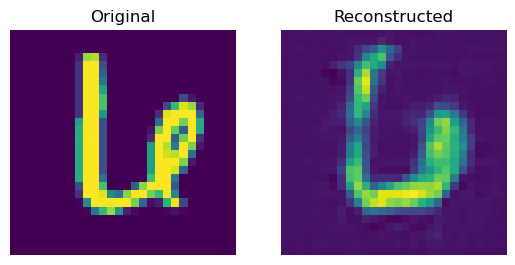

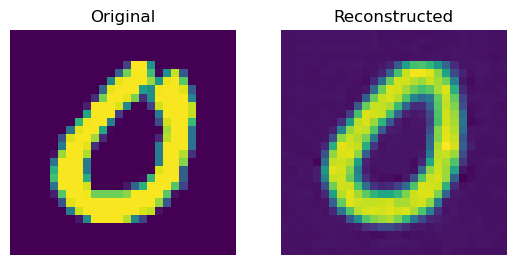

In [29]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 3)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

1/1 [==============================] - 0s 96ms/step


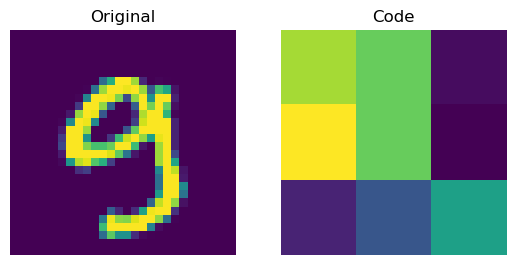

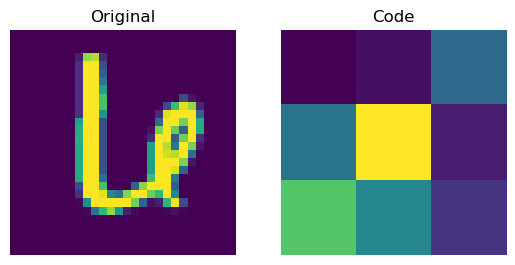

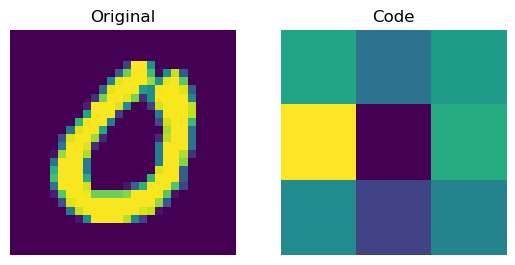

In [30]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()